<a href="https://colab.research.google.com/github/hritik880/Waste-Classifier/blob/master/waste_classifier_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import zipfile as zf
import shutil
import re
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!cp /content/gdrive/"My Drive"/dataset-resized.zip ./

In [5]:
files = zf.ZipFile("/content/dataset-resized.zip",'r')
files.extractall()
files.close()

In [6]:
!rm /content/dataset-resized.zip

In [7]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [11]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_gen = train_datagen.flow_from_directory(r'/content/data/train',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    class_mode='categorical')

Found 1262 images belonging to 6 classes.


In [16]:
test_gen = test_datagen.flow_from_directory(r'/content/data/valid',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    color_mode="rgb",
                                                    shuffle =False,
                                                    class_mode='categorical')

Found 630 images belonging to 6 classes.


In [71]:
from tensorflow.keras.layers import Input,Convolution2D ,GlobalAveragePooling2D,MaxPooling2D ,Dense, Flatten, Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report


In [73]:
inception_base = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = inception_base.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(6, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = Model(inputs=inception_base.input, outputs=predictions)

In [75]:
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [77]:
output_dir = r'/content/gdrive/My Drive/Resnet_wc'
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1,
                                                factor=0.1, min_lr=0.00001)
save_model = ModelCheckpoint(filepath=output_dir + "/resnet_model.h5", monitor='val_loss', verbose=1,
                                 save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_25 (Functional)   (None, 131072)            23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16777344  
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 40,365,830
Trainable params: 16,778,118
Non-trainable params: 23,587,712
_________________________________________________________________


In [78]:
batch_size = 16
history= inception_transfer.fit_generator(train_gen,
                    epochs=50,
                    steps_per_epoch=(train_gen.n // batch_size) ,
                    validation_data = test_gen,
                    validation_steps = (test_gen.n // batch_size),
                    verbose =1 ,
                    callbacks=[learning_rate_reduction, save_model])

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 1.5956 - accuracy: 0.3828
Epoch 00001: val_loss improved from inf to 1.85750, saving model to /content/gdrive/My Drive/Resnet_wc/resnet_model.h5
78/78 [==============================] - 27s 347ms/step - loss: 1.5956 - accuracy: 0.3828 - val_loss: 1.8575 - val_accuracy: 0.2003
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 1.1268 - accuracy: 0.6388
Epoch 00002: val_loss did not improve from 1.85750
78/78 [==============================] - 25s 316ms/step - loss: 1.1268 - accuracy: 0.6388 - val_loss: 1.9265 - val_accuracy: 0.2003
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.8892 - accuracy: 0.7199
Epoch 00003: val_loss did not improve from 1.85750
78/78 [==============================] - 24s 310ms/step - loss: 0.8892 - accuracy: 0.7199 - val_loss: 2.2099 - val_accuracy: 0.1442
Epoch 4/50
78/78 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.7544
Epoch 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


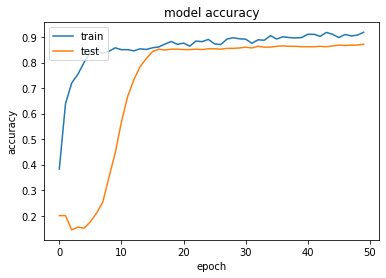

In [79]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

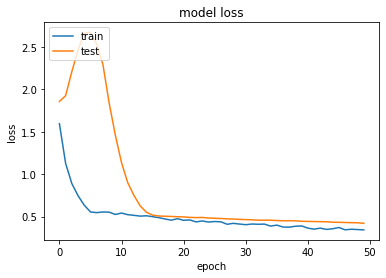

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
inception_transfer.load_weights((output_dir + "/resnet_model.h5"))
train_gen.reset()
test_gen.reset()

In [85]:
verbose = 1
loss_t, accuracy_t = inception_transfer.evaluate(train_gen, steps=(train_gen.n // batch_size), verbose=verbose)
loss, accuracy = inception_transfer.evaluate(test_gen, steps=(test_gen.n // batch_size) , verbose=verbose)
print("Train: accuracy = %f  ;  loss_v = %f" % (accuracy_t, loss_t))
print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))

39/39 [==============================] - 3s 75ms/step - loss: 0.4202 - accuracy: 0.8718
Train: accuracy = 0.959135  ;  loss_v = 0.215453
Test: accuracy = 0.871795  ;  loss_v = 0.420204


In [86]:
y_pred = inception_transfer.predict(test_gen, steps=(test_gen.n // batch_size)+1, verbose=verbose)
y_true = test_gen.classes[test_gen.index_array]

40/40 [==============================] - 3s 78ms/step


In [87]:
y_pred_int = np.argmax(y_pred,axis =1)

In [89]:
labels = os.listdir(r'/content/data/train')

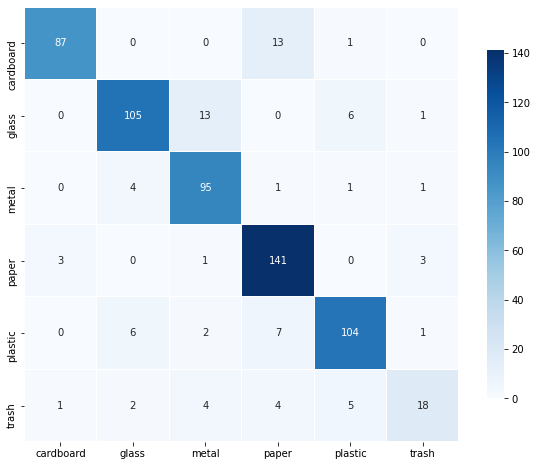

In [173]:
cm = confusion_matrix(y_true, y_pred_int)
classes = labels
df_cm = pd.DataFrame(cm, waste_types, waste_types)
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8},cmap="Blues")
if output_dir:
    plt.savefig(output_dir + "/resnet_confusion_matrix.png")

In [92]:
class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels ,output_dict=True)

In [93]:
df = pd.DataFrame(class_report).transpose()
df.to_csv(output_dir + '/classification_report')

In [106]:
!mv /content/data/test_image/test/test /content/data/test_parent

In [108]:
!rm /content/data/test_image/test

rm: cannot remove '/content/data/test_image/test': Is a directory


In [111]:
final_test_datagen = ImageDataGenerator(
                rescale =1./255)
final_test_gen =  final_test_datagen.flow_from_directory(r'/content/data/test_parent',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    color_mode="rgb",
                                                    shuffle =False,
                                                    class_mode=None)

Found 635 images belonging to 2 classes.


In [127]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [157]:
labels

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [129]:
pred = inception_transfer.predict_generator(final_test_gen)

In [130]:
predicted_class_indices=np.argmax(pred,axis=1)

In [140]:
y_hat = [labels[k] for k in predicted_class_indices]

In [134]:
y = []
for label_path in final_test_gen.filenames:
  y.append(str(label_path))
    

In [136]:
y  = [w.replace('test/', '') for w in y]

In [138]:
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [161]:
cm = confusion_matrix(y,y_hat,l)
print(cm)

[[ 89   0   0  11   1   0]
 [  0  98  16   2  10   0]
 [  0   3  87   1   6   6]
 [  1   2   2 141   1   2]
 [  0   6   8   1 105   1]
 [  0   3   6   7   2  17]]


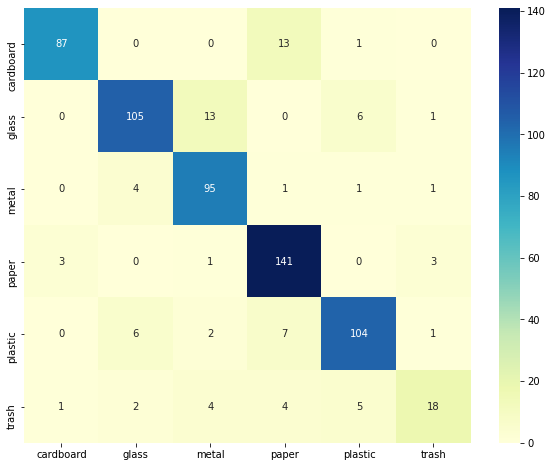

In [174]:
f_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(f_cm,annot=True,fmt="d",cmap="YlGnBu")
if output_dir:
    plt.savefig(output_dir + "/resnet_test_confusion_matrix.png")

In [167]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

accuracy = correct/sum(sum(cm))
accuracy

0.8456692913385827